# Learning a sensorimotor model with a context

## Setting environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from explauto import Environment
arm = Environment.from_configuration('simple_arm', 'low_dimensional')

Let's define a variation of the SimpleArm environment to enable $\Delta$ actions.

In [3]:
from explauto.environment.context_environment import ContextEnvironment
from explauto.environment.simple_arm import SimpleArmEnvironment
from explauto.environment import environments

env_cls = SimpleArmEnvironment
env_conf = environments['simple_arm'][1]['low_dimensional']

rest_position = [0]*3

context_mode = dict(choose_m=True,
                    context_dims=[0,1],
                    rest_position=rest_position,
                    dm_bounds=[[-0.2, -0.2, -0.2],
                              [0.2, 0.2, 0.2]],
                    ds_bounds=[[-0.2, -0.2],
                              [0.2, 0.2]])

environment = ContextEnvironment(env_cls, env_conf, context_mode)

Populating the interactive namespace from numpy and matplotlib


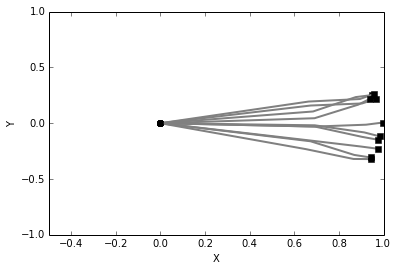

In [4]:
# Create the axes for plotting:
%pylab inline
ax = axes()

motor_configurations = environment.random_motors(n=10) / 2

# Plotting 10 random motor configurations:
for m in motor_configurations:
    environment.update(m, reset=False)
    environment.plot(ax)

## Learning a sensorimotor model with action context

Now the database contains tuples of $(M, \Delta M, S, \Delta S)$ so we adapt the sensorimotor model dimensions.

In [5]:
from explauto import SensorimotorModel
from explauto.utils.config import make_configuration

conf = make_configuration(np.hstack((arm.conf.m_mins, arm.conf.m_mins / 4)), 
                          np.hstack((arm.conf.m_maxs, arm.conf.m_maxs / 4)),
                          np.hstack((arm.conf.s_mins, arm.conf.s_mins / 4)),
                          np.hstack((arm.conf.s_maxs, arm.conf.s_maxs / 4)))

sm_model = SensorimotorModel.from_configuration(conf, 'NN', 'default')

Populating the interactive namespace from numpy and matplotlib
Size of database: 2000


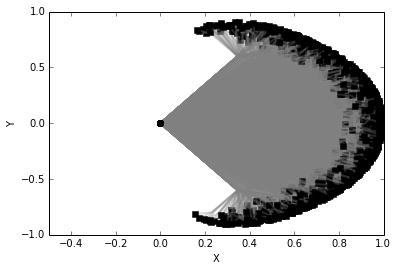

In [6]:
# Create the axes for plotting:
%pylab inline
ax = axes()

for mdm in environment.random_motors(n=2000):
    m = mdm[:3]
    dm = mdm[3:]
    context = environment.current_sensori_position
    sds = environment.update(mdm, reset=True)    
    sm_model.update(np.hstack((m, dm)), np.hstack((context, sds[2:4])))
    environment.plot(ax, alpha=0.3)
    #draw()
    
print "Size of database:", sm_model.size()

Predict without context: predicted s= [ 0.96571893 -0.26708816] predicted ds= [-0.07283323  0.03036821]


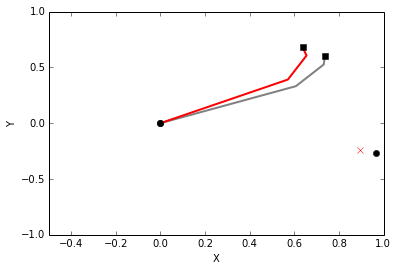

In [7]:
# Predict without sensori context
m = [0.5]*3
dm = [0.1]*3
sds = sm_model.forward_prediction(np.hstack((m, dm)))
s = sds[0:2]
ds = sds[2:4]
print "Predict without context: predicted s=", s, "predicted ds=", ds 

ax = axes()
environment.update(np.hstack((m, [0]*3)))
environment.plot(ax)
environment.update(np.hstack((m, dm)))
environment.plot(ax, color='red')
ax.plot(*s, marker='o', color='k')
ax.plot(*list(np.array(s)+np.array(ds)), marker='x', color='red')


Predict with    context: predicted s= [ 0.71558951  0.67004917] predicted ds= [-0.08611541  0.01663136]


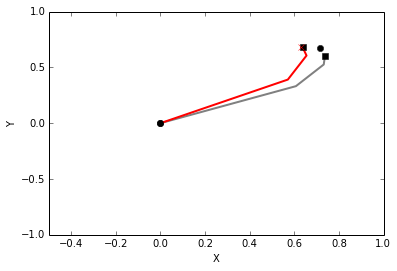

In [8]:
# Predict with sensori context
m = [0.5]*3
dm = [0.1]*3
c = [0.6] # context
c_dims = [1] # hand y position
sds = sm_model.predict_given_context(np.hstack((m, dm)), c, c_dims)
s = sds[0:2]
ds = sds[2:4]
print "Predict with    context: predicted s=", s, "predicted ds=", ds 

ax = axes()
environment.update(np.hstack((m, [0]*3)))
environment.plot(ax)
environment.update(np.hstack((m, dm)))
environment.plot(ax, color='red')
ax.plot(*s, marker='o', color='k')
ax.plot(*list(np.array(s)+np.array(ds)), marker='x', color='red')

current m =  [0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
current s =  [1.0201358825293456, 0.15176431742421992]
Inverse with context: dm = [ 0.16527484  0.04386742 -0.11261125]
Goal ds= [-0.2, 0.4] Reached ds= [-0.08178351  0.1523342 ]


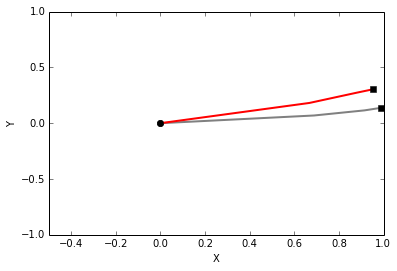

In [9]:
# Inverse with sensorimotor context: dM <- i(M, S, dS)

ax = axes()
m = [0.1]*3
environment.update(np.hstack((m, [0]*3)))
environment.plot(ax)

in_dims = range(3) + range(6,10)
out_dims = range(3, 6)
ds_goal = [-0.2, 0.4]

m_current = list(environment.current_motor_position)
s_current = list(environment.current_sensori_position)
print "current m = ", m_current
print "current s = ", s_current

dm = sm_model.infer(in_dims, 
                    out_dims, 
                    m_current + s_current + ds_goal)

print "Inverse with context: dm =", dm 
environment.update(np.hstack((m_current, dm)))
environment.plot(ax, color='red')

print "Goal ds=", ds_goal, "Reached ds=", environment.current_sensori_position - s_current




Inverse without context: m = [ 0.43143155 -0.83453111  1.02264079] dm = [ 0.16319512 -0.14772055 -0.05054763]


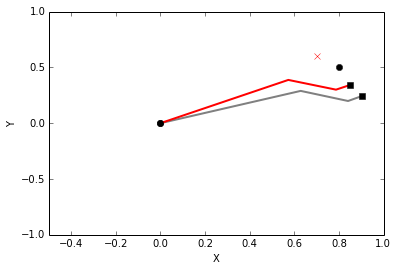

In [10]:
# Inverse without context: (M, dM) <- i(S, dS)

sm_model.mode = "exploit" # no exploration noise

s_goal = [0.8, 0.5]
ds_goal = [-0.1, 0.1]
mdm = sm_model.inverse_prediction(s_goal + ds_goal)
m = mdm[0:3]
dm = mdm[3:6]
print "Inverse without context: m =", m, "dm =", dm 

ax = axes()
environment.update(np.hstack((m, [0]*3)))
environment.plot(ax)
environment.update(np.hstack((m, dm)))
environment.plot(ax, color='red')
ax.plot(*s_goal, marker='o', color='k')
ax.plot(*list(np.array(s_goal)+np.array(ds_goal)), marker='x', color='red')

## Goal babbling using interest models

In [11]:
from explauto.interest_model.discrete_progress import DiscretizedProgress, competence_dist

im_model = DiscretizedProgress(conf, conf.s_dims, **{'x_card': 1000,
                                                     'win_size': 20,
                                                     'measure': competence_dist})

In [12]:
# Or with Random interest model
#from explauto.interest_model.random import RandomInterest
#im_model = RandomInterest(conf, conf.s_dims)

Sampling with context:

In [13]:
c = [0.7, 0.6] # context
c_dims = [0, 1] # hand position's dimensions

ds = im_model.sample_given_context(c, c_dims)

#print im_model.discrete_progress.progress()
print "Sampling interesting goal with hand position=", c, ": ds=", ds

Sampling interesting goal with hand position= [0.7, 0.6] : ds= [ 0.16996912  0.15831848]


Here we run the whole procedure without resetting the arm and environment to initial position.
It might be useful to test reseting e.g. each 50 iterations.

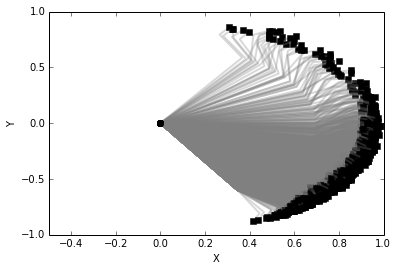

In [72]:
# Reset environment
environment.reset()

# Reset sensorimotor model
sm_model = SensorimotorModel.from_configuration(conf, 'NN', 'default')

c_dims = [0, 1] # hand position's dimensions

# Add one point to boostrap sensorimotor model
sm_model.update([0.]*6, np.hstack((environment.current_sensori_position, [0., 0.])))
    
ax = axes()

for _ in range(2000):
    # Get current context
    c = environment.current_sensori_position
    # sample a random sensory goal using the interest model:
    ds_g = im_model.sample_given_context(c, c_dims)
    #print "sample ds=", ds_g
    # infer a motor command to reach that goal using the sensorimotor model:
    mdm = sm_model.inverse_prediction(np.hstack((c, ds_g)))
    m = mdm[0:3]
    dm = mdm[3:6]
    # execute this command and observe the corresponding sensory effect:
    sds = environment.update(mdm)
    s = sds[:2]
    ds = sds[2:]
    # update the sensorimotor model:
    sm_model.update(mdm, sds)
    # update interest model
    im_model.update(hstack((mdm, sds)), hstack((mdm, c, ds_g)))
    # plot arm
    environment.plot(ax, alpha=0.3)
    

In [15]:
from explauto import Agent
agent = Agent(environment.conf, sm_model, im_model, context_dims=[0, 1])

In [73]:
from explauto import Experiment
from explauto.utils import rand_bounds

expe = Experiment(environment, agent)

from explauto.experiment import make_settings

random_goal_babbling = make_settings(environment='simple_arm', environment_config = 'low_dimensional',
                                     babbling_mode='goal', 
                                     interest_model='discretized_progress',
                                     sensorimotor_model='LWLR-BFGS',
                                     context_mode=context_mode)

expe = Experiment.from_settings(random_goal_babbling)

expe.evaluate_at([100, 200, 400], 
                 rand_bounds(np.vstack(([0.8, -0.1, -0.1, -0.2], [1., 0.1, 0.1, 0.2])), n=100))

In [74]:
expe.run()

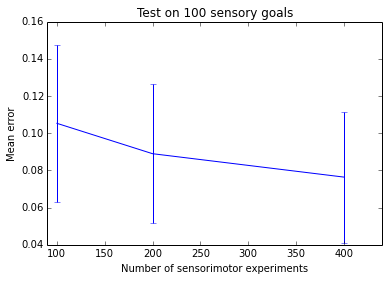

In [75]:
ax = axes()
expe.log.plot_learning_curve(ax)

401
Inverse without context: m = [ 0.57221999  0.00241133 -0.37292851] dm = [ 0.10774472  0.07458615  0.2       ]


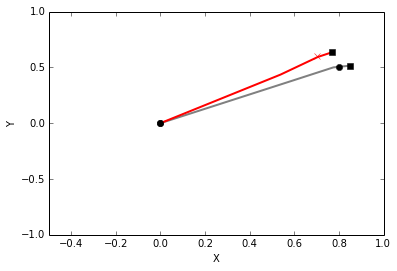

In [76]:
# Inverse without context: (M, dM) <- i(S, dS)
sm_model = expe.ag.sensorimotor_model
sm_model.mode = "exploit" # no exploration noise
print sm_model.size()
s_goal = [0.8, 0.5]
ds_goal = [-0.1, 0.1]
mdm = sm_model.inverse_prediction(s_goal + ds_goal)
m = mdm[0:3]
dm = mdm[3:6]
print "Inverse without context: m =", m, "dm =", dm 

ax = axes()
environment.update(np.hstack((m, [0]*3)))
environment.plot(ax)
environment.update(np.hstack((m, dm)))
environment.plot(ax, color='red')
ax.plot(*s_goal, marker='o', color='k')
ax.plot(*list(np.array(s_goal)+np.array(ds_goal)), marker='x', color='red')

CMAES: check sigma m vs sigma dm -> ratio ?
here: choose m 
if not choose m ?